# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)

In [2]:
# simulation output folder
# experiment_name = 'level0_Tmax_sensitivity_run_1'
experiment_name = 'explore_demand_test'

# load Java simulation data
# experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'
experiment_folder = fr'..\data\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'
collision_output = 'collisionOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # open zip file (remove .csv form file name)
            try:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number
                # add input values to the dataframe if the input file is specified
                if input_file is not None:
                    # open input zip file
                    with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                        # read input csv
                        with zip_ref.open(input_file) as input_data_file:
                            df_input = pd.read_csv(input_data_file)
                    # broadcast input data to all rows in df_interest
                    for col in df_input.columns:
                        df_interest[col] = df_input[col].iloc[0]
    
                # add this data to the main DataFrame
                df = pd.concat([df, df_interest])
            except:
                print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile or is empty.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

In [5]:
# get GTU data
variables = ['time', 'gtu_id', 'headway_time', 'desired_headway_time']
df_gtu = load_dataframe(variables, experiment_folder, sequence_output, input_values)
# only include sensitivity analysis parameter from input data
df_gtu = df_gtu[variables + ['seed', 'run', 'sensitivity_analysis_value']]
# rename column of the sensitivity analysis parameter
df_gtu.rename(columns = {'sensitivity_analysis_value':'t_max'}, inplace = True)

In [6]:
# remove collisions (these are not "unsafe" but rather an error in the simulation because vehicles can change lanes through a hack)
# 60 runs can cause at least 60 collisions, when it is more than 4 times the number of runs maybe other collisions do also occur
print(len(df_gtu[df_gtu['headway_time'] <= 0]))

118


In [7]:
# get collision output
variables = ['time', 'id', 'leader_id']
df_collisions = load_dataframe(variables, experiment_folder, collision_output, input_values)

# only include seed and run info from input data
df_collisions = df_collisions[['seed', 'run'] + variables]

An error occured when trying to read data from: ..\data\explore_demand_test\seed_0\run_1. This folder may contain a BadZipFile or is empty.
An error occured when trying to read data from: ..\data\explore_demand_test\seed_0\run_10. This folder may contain a BadZipFile or is empty.
An error occured when trying to read data from: ..\data\explore_demand_test\seed_0\run_13. This folder may contain a BadZipFile or is empty.
An error occured when trying to read data from: ..\data\explore_demand_test\seed_0\run_17. This folder may contain a BadZipFile or is empty.
An error occured when trying to read data from: ..\data\explore_demand_test\seed_0\run_19. This folder may contain a BadZipFile or is empty.
An error occured when trying to read data from: ..\data\explore_demand_test\seed_0\run_2. This folder may contain a BadZipFile or is empty.
An error occured when trying to read data from: ..\data\explore_demand_test\seed_0\run_21. This folder may contain a BadZipFile or is empty.
An error occure

In [8]:
def remove_collided_gtus(df, df_coll):
    # create collision dictionary
    collision_dict = {}
    for _, row in df_coll.iterrows():
        seed_run_key = str(row['seed']) + '_' + str(row['run'])
        # initialise set for seed run combination
        if seed_run_key not in collision_dict:
            collision_dict[seed_run_key] = set()
        # add GTUs to the set
        collision_dict[seed_run_key].add(row['id'])
        collision_dict[seed_run_key].add(row['leader_id'])

    # function to determine whether GTU was involved in a collision
    def is_involved_in_collision(row):
        seed_run_key = str(row['seed']) + '_' + str(row['run'])
        return seed_run_key in collision_dict and row['gtu_id'] in collision_dict[seed_run_key]

    # filter dataframe for collisions
    df_filtered = df[~df.apply(is_involved_in_collision, axis=1)]

    # return new dataframe
    return df_filtered

df_gtu_new = remove_collided_gtus(df_gtu, df_collisions)
print(len(df_gtu_new[df_gtu_new['headway_time'] < 0]))

1


In [9]:
# calculate how many data points are removed because of collisions
print(f'{(len(df_gtu) - len(df_gtu_new)) / len(df_gtu) * 100}% of data points cleaned because of collisions.')
print(f'Remaining data points with headway time under or equal to 0: {len(df_gtu_new[df_gtu_new["headway_time"] <= 0])}')

0.6644982575618121% of data points cleaned because of collisions.
Remaining data points with headway time under or equal to 0: 1


In [10]:
# remove these collisions
df_gtu_scope = df_gtu_new[df_gtu_new['headway_time'] > 0]
# focus on smaller time headways, a time headway of 100 seconds is not interesting
df_gtu_scope = df_gtu_scope[df_gtu_scope['headway_time'] < 2]

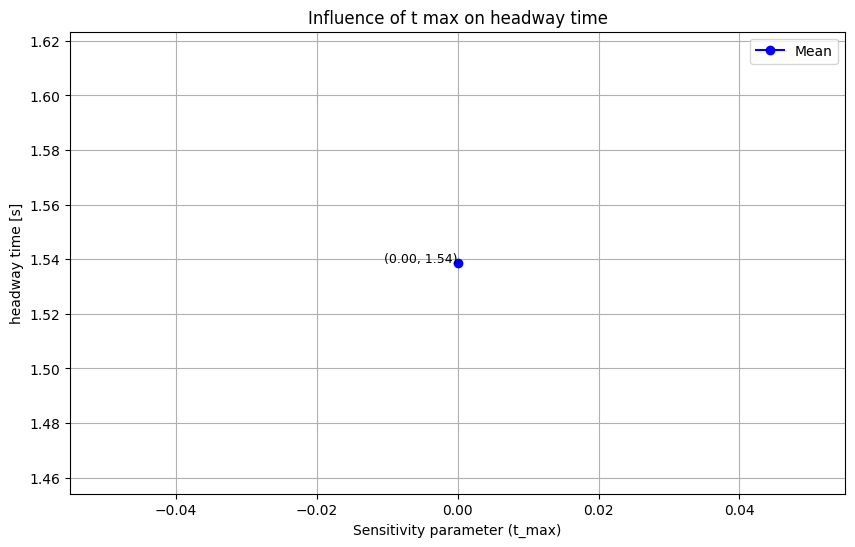

In [11]:
def sensitivity_analysis_line_plot(df, sens_param, dependent_param):
    # remove NaN and inf values in time headway since not all data points have a leading vehicle
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=[dependent_param])
    
    # group by the sensitivity parameter and calculate mean, min, and max of the dependent parameter
    stats_by_sens_param = df.groupby(sens_param)[dependent_param].agg(['mean', 'min', 'max']).reset_index()
    stats_by_sens_param.rename(columns={'mean': f'mean_{dependent_param}', 'min': f'min_{dependent_param}', 'max': f'max_{dependent_param}'}, inplace=True)
    
    # sort values by the sensitivity parameter to ensure correct plotting order
    stats_by_sens_param = stats_by_sens_param.sort_values(by=sens_param)
    
    # plot the mean, min, and max values against the sensitivity analysis parameter
    plt.figure(figsize=(10, 6))
    plt.plot(stats_by_sens_param[sens_param], stats_by_sens_param[f'mean_{dependent_param}'], marker='o', color='blue', label='Mean')
    # plt.fill_between(stats_by_sens_param[sens_param], 
    #                  stats_by_sens_param[f'min_{dependent_param}'], 
    #                  stats_by_sens_param[f'max_{dependent_param}'], 
    #                  color='lightblue', alpha=0.3, label='Range (Min to Max)')

    # display data point values
    for i, row in stats_by_sens_param.iterrows():
        plt.text(row[sens_param], row[f'mean_{dependent_param}'], f'({row[sens_param]:.2f}, {row[f"mean_{dependent_param}"]:.2f})', fontsize=9, ha='right')
    
    # labels and title
    plt.xlabel(f'Sensitivity parameter ({sens_param})')
    plt.ylabel(f'{dependent_param.replace("_", " ")} [s]')
    plt.title(f'Influence of {sens_param.replace("_", " ")} on {dependent_param.replace("_", " ")}')
    plt.grid(True)
    plt.legend()
    plt.show()

# show influence of t_max on headway_time
sensitivity_analysis_line_plot(df_gtu_scope, 't_max', 'headway_time')

### Conclusion
The plot for mean headway times between 0 and 2 seconds shows that a higher Tmax indeed 